In [1]:
import numpy as np
import os
current_path = os.getcwd()
PETITE_home_dir= current_path.split('examples')[0]
dictionary_dir = "data/"

In [2]:
# import src
import sys
sys.path.append(PETITE_home_dir)
from src.shower import *
import pickle as pk
from matplotlib import pyplot as plt
from src.particle import Particle, meson_twobody_branchingratios
from tqdm import tqdm
import pickle as pk
from src.physical_constants import m_kaon_pm, c_tau_kaon_pm
print(m_kaon_pm, c_tau_kaon_pm)


0.49367700000000003 3.714


## Get $\pi^0$, $K^\pm$ and $\eta$ beam from 1000 POT shower

In [3]:
pion_beam = np.loadtxt(PETITE_home_dir+dictionary_dir+'Pi0_400GeVProtons_1e3POT.txt')
NPOT = 1e3
NSamples_pion = len(pion_beam)

In [4]:
kaon_beam = np.loadtxt(PETITE_home_dir+dictionary_dir+'kaon_momenta_1000POT.txt')
NSamples_kaon = len(kaon_beam)

In [5]:
eta_beam = np.loadtxt(PETITE_home_dir+dictionary_dir+'eta_momenta_1000POT.txt')
NSamples_eta = len(eta_beam)

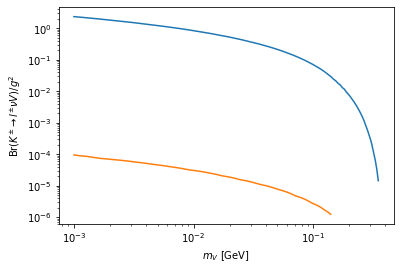

0.8427267550926746


In [6]:
br_vs_mv = np.loadtxt(PETITE_home_dir+dictionary_dir+'br_muon.txt')
mv = br_vs_mv[:,0]
br = br_vs_mv[:,1]/(1e-3)**2

br_vs_mv_e = np.loadtxt(PETITE_home_dir+dictionary_dir+'br_electron.txt')
mv_e = br_vs_mv_e[:,0]
br_e = br_vs_mv_e[:,1]/(1e-3)**2
# interpolate 
from scipy import interpolate
br_interp = interpolate.interp1d(mv, br, kind='linear')
br_interp_e = interpolate.interp1d(mv_e, br_e, kind='linear')
mv_new = np.logspace(-3, np.log10(0.35), 1000)
br_new = br_interp(mv_new)
mv_new_e = np.logspace(-3, np.log10(0.14), 1000)
br_new_e = br_interp_e(mv_new_e)
plt.plot(mv_new, br_new)
plt.plot(mv_new_e, br_new_e)
plt.xscale('log')
plt.xlabel(r'$m_{V}$ [GeV]')
plt.ylabel(r'Br($K^{\pm} \rightarrow l^{\pm} \nu V$)/$g^2$')
plt.yscale('log')
plt.show()

print(br_interp(0.01))


In [7]:
# decay weight for kaon decay
def decay_weight(mV, lepton = "mu"):
    if lepton == "mu":
        return br_interp(mV)
    elif lepton == "e":
        return br_interp_e(mV)
    else:
        raise ValueError("lepton must be either mu or e")

# decay weight for pion and eta decay
def decay_weight_twobody(particle, mV):
    mass_ratio = mV/particle.get_ids()["mass"]
    if mass_ratio >= 1.0:
        return 0.0
    else:
        return 2*(1.0 - mass_ratio**2)**3*meson_twobody_branchingratios[particle.get_ids()["PID"]]


In [8]:
def transverse_position(particle, z):
    x0, y0, z0 = particle.get_r0()
    E, px, py, pz = particle.get_p0()

    T = (z-z0)/pz #proxy for the time of propagation from z0 to z in the longitudinal direction
    xf, yf = x0 + T*px, y0 + T*py
    return [xf, yf]

def detector_cut(particle_list, detector_positions, detector_radius, method="Sample", energy_cut=None, detector_inner_radius=0.0):
    particle_list = np.array(particle_list)

    if energy_cut is not None:
        energies = np.array([p0.get_p0()[0] for p0 in particle_list])
        particle_list = particle_list[np.where(energies < energy_cut[1],True,False)*np.where(energies>energy_cut[0],True,False)]

    if len(particle_list) == 0:
        if method == "Sample":
            return [[] for i in range(len(detector_positions))]
        else:
            return [0.0 for i in range(len(detector_positions))]

    rT = np.linalg.norm([transverse_position(p0, detector_positions) for p0 in particle_list], axis=1)

    pass_cuts_where = np.transpose(np.where(rT > detector_inner_radius, True, False)*np.where(rT < detector_radius, True, False))
#    pass_cuts_where = np.transpose(np.where(rT < detector_radius))

    pass_cuts = [particle_list[pass_cuts_where[i]] for i in range(len(pass_cuts_where))]

    if method == "Sample":
        return pass_cuts
    elif method == "Efficiency":
        return [np.sum([p0.get_ids()["weight"] for p0 in pass_cuts[ii]])/np.sum([p0.get_ids()["weight"] for p0 in particle_list]) for ii in range(len(pass_cuts))]
    elif method == "TotalWeight":
        return [np.sum([p0.get_ids()["weight"] for p0 in pass_cuts[ii]]) for ii in range(len(pass_cuts))]

## $\pi^0 \rightarrow V\gamma$

In [9]:
# pion -> V + gamma
#mV_list = np.logspace(-3, np.log10(0.995*m_pi0), 31)
mV_list = [0.010]
NewShower_pion = [[] for mV in mV_list]
nperpion = 5
for p0 in tqdm(pion_beam[:,:4]):
    r0 = [0, 0, 0]
    pdict = {"PID":111, "mass":m_pi0, "stability":"short-lived", "weight":1/(NPOT*nperpion)}
    part = Particle(p0, r0, pdict)

    for mVi, mV in enumerate(mV_list):
      wg = decay_weight_twobody(part, mV)
      V_dict = {"mass":mV, "PID":4900022,
            "weight":part.get_ids()["weight"]*wg,
            "parent_PID":part.get_ids()["PID"], "parent_ID":part.get_ids()["ID"],
            "ID":2*(part.get_ids()["ID"])+1, "generation_number":part.get_ids()["generation_number"]+1,
            "generation_process":process_code}
      gamma_dict = {"mass":0, "PID":22}
      for jj in range(nperpion):
            V = part.two_body_decay(gamma_dict, V_dict)[1]
            NewShower_pion[mVi].append(V)

100%|██████████| 4083/4083 [00:02<00:00, 1752.94it/s]


In [10]:
# pion -> V + gamma
#mV_list = np.logspace(-3, np.log10(0.995*m_pi0), 31)
mV_list = [0.030]
NewShower_pion_30MeV = [[] for mV in mV_list]
nperpion = 5
for p0 in tqdm(pion_beam[:,:4]):
    r0 = [0, 0, 0]
    pdict = {"PID":111, "mass":m_pi0, "stability":"short-lived", "weight":1/(NPOT*nperpion)}
    part = Particle(p0, r0, pdict)

    for mVi, mV in enumerate(mV_list):
      wg = decay_weight_twobody(part, mV)
      V_dict = {"mass":mV, "PID":4900022,
            "weight":part.get_ids()["weight"]*wg,
            "parent_PID":part.get_ids()["PID"], "parent_ID":part.get_ids()["ID"],
            "ID":2*(part.get_ids()["ID"])+1, "generation_number":part.get_ids()["generation_number"]+1,
            "generation_process":process_code}
      gamma_dict = {"mass":0, "PID":22}
      for jj in range(nperpion):
            V = part.two_body_decay(gamma_dict, V_dict)[1]
            NewShower_pion_30MeV[mVi].append(V)

100%|██████████| 4083/4083 [00:01<00:00, 2627.74it/s]


In [11]:
# pion -> V + gamma
#mV_list = np.logspace(-3, np.log10(0.995*m_pi0), 31)
mV_list = [0.100]
NewShower_pion_100MeV = [[] for mV in mV_list]
nperpion = 5
for p0 in tqdm(pion_beam[:,:4]):
    r0 = [0, 0, 0]
    pdict = {"PID":111, "mass":m_pi0, "stability":"short-lived", "weight":1/(NPOT*nperpion)}
    part = Particle(p0, r0, pdict)

    for mVi, mV in enumerate(mV_list):
      wg = decay_weight_twobody(part, mV)
      V_dict = {"mass":mV, "PID":4900022,
            "weight":part.get_ids()["weight"]*wg,
            "parent_PID":part.get_ids()["PID"], "parent_ID":part.get_ids()["ID"],
            "ID":2*(part.get_ids()["ID"])+1, "generation_number":part.get_ids()["generation_number"]+1,
            "generation_process":process_code}
      gamma_dict = {"mass":0, "PID":22}
      for jj in range(nperpion):
            V = part.two_body_decay(gamma_dict, V_dict)[1]
            NewShower_pion_100MeV[mVi].append(V)

100%|██████████| 4083/4083 [00:01<00:00, 2110.27it/s]


## $K^\pm\rightarrow l^{\pm} \nu V$

In [12]:
def prob_decay(particle, detector_front, detector_length, ctau0):
    if particle.get_p0()[3] < 0.0:
        return 0.0
    dist0 = np.linalg.norm(detector_front - particle.get_r0())
    E = particle.get_p0()[0]
    gamma = E/particle.get_ids()['mass']
    beta = np.sqrt(1 - 1/gamma**2)
    ctau = ctau0*gamma*beta

    return np.exp(-dist0/ctau)*(1 - np.exp(-detector_length/ctau))

def prob_decay_meson(particle, target_length, ctau0):
    if particle.get_p0()[3] < 0.0:
        return 0.0
    E = particle.get_p0()[0]
    gamma = E/particle.get_ids()['mass']
    beta = np.sqrt(1 - 1/gamma**2)
    ctau = ctau0*gamma*beta

    return 1 - np.exp(-target_length/ctau)

def prob_interaction(particle, target_length, interaction_length):

    return 1 - np.exp(-target_length/interaction_length)

def penalty_factor(particle, interaction_length, ctau0):
    # probability of decay before interaction for (relatively) long-lived particles
    if particle.get_p0()[3] < 0.0:
        return 0.0
    E = particle.get_p0()[0]
    gamma = E/particle.get_ids()['mass']
    beta = np.sqrt(1 - 1/gamma**2)
    ctau = ctau0*gamma*beta

    return interaction_length/ctau

In [13]:
# kaon -> mu + V + numu
# mV = 10 MeV
c_tau_kaon_pm = 3.714 #m
mV_list = [0.010]
NewShower_e = [[] for mV in mV_list]
NewShower_mu = [[] for mV in mV_list]
NewShower_lelmu = [[] for mV in mV_list]
nperkaon = 5
SHiP_target_length = 116 #cm
kaon_pm_interaction_length = 22.875 #cm
for p0 in tqdm(kaon_beam[:,:4]):
    r0 = [0, 0, 0]
    pdict = {"PID":321, "mass":m_kaon_pm, "stability":"short-lived", "weight":1/(NPOT*nperkaon)}
    part = Particle(p0, r0, pdict)

    for mVi, mV in enumerate(mV_list):
      wg_e = decay_weight(mV, lepton = "e") * penalty_factor(part, kaon_pm_interaction_length/100, c_tau_kaon_pm)
      wg_mu = decay_weight(mV, lepton = "mu") * penalty_factor(part, kaon_pm_interaction_length/100, c_tau_kaon_pm)
      #print(penalty_factor(part, kaon_pm_interaction_length/100, c_tau_kaon_pm))
      #print(prob_decay_meson(part, SHiP_target_length, c_tau_kaon_pm)/prob_interaction(part, SHiP_target_length, kaon_pm_interaction_length))
      V_dict_e = {"mass":mV, "PID":4900022,
            "weight":part.get_ids()["weight"]*wg_e,
            "parent_PID":part.get_ids()["PID"], "parent_ID":part.get_ids()["ID"],
            "ID":2*(part.get_ids()["ID"])+1, "generation_number":part.get_ids()["generation_number"]+1,
            "generation_process":process_code}
      V_dict_mu = {"mass":mV, "PID":4900022,
            "weight":part.get_ids()["weight"]*wg_mu,
            "parent_PID":part.get_ids()["PID"], "parent_ID":part.get_ids()["ID"],
            "ID":2*(part.get_ids()["ID"])+1, "generation_number":part.get_ids()["generation_number"]+1,
            "generation_process":process_code}
      electron_dict = {"mass":0.000511, "PID":11}
      muon_dict = {"mass":0.105, "PID":13}
      neutrino_dict = {"mass":0.0, "PID":14}
      for jj in range(nperkaon):
            V_e = part.three_body_decay(electron_dict, neutrino_dict, V_dict_e)[2]
            V_mu = part.three_body_decay(muon_dict, neutrino_dict, V_dict_mu)[2]
            NewShower_e[mVi].append(V_e)
            NewShower_mu[mVi].append(V_mu)
            NewShower_lelmu[mVi].extend([V_e, V_mu])

100%|██████████| 598/598 [00:01<00:00, 453.40it/s]


In [15]:
# kaon -> mu + V + numu
# mV = 30 MeV
mV_list = [0.030]
NewShower_30MeV_e = [[] for mV in mV_list]
NewShower_30MeV_mu = [[] for mV in mV_list]
NewShower_30MeV_lelmu = [[] for mV in mV_list]
nperkaon = 5
SHiP_target_length = 116 #cm
kaon_pm_interaction_length = 22.875 #cm
for p0 in tqdm(kaon_beam[:,:4]):
    r0 = [0, 0, 0]
    pdict = {"PID":321, "mass":m_kaon_pm, "stability":"short-lived", "weight":1/(NPOT*nperkaon)}
    part = Particle(p0, r0, pdict)

    for mVi, mV in enumerate(mV_list):
      wg_e = decay_weight(mV, lepton = "e")*penalty_factor(part, kaon_pm_interaction_length/100, c_tau_kaon_pm)
      wg_mu = decay_weight(mV, lepton = "mu")*penalty_factor(part, kaon_pm_interaction_length/100, c_tau_kaon_pm)
      V_dict_e = {"mass":mV, "PID":4900022,
            "weight":part.get_ids()["weight"]*wg_e,
            "parent_PID":part.get_ids()["PID"], "parent_ID":part.get_ids()["ID"],
            "ID":2*(part.get_ids()["ID"])+1, "generation_number":part.get_ids()["generation_number"]+1,
            "generation_process":process_code}
      V_dict_mu = {"mass":mV, "PID":4900022,
            "weight":part.get_ids()["weight"]*wg_mu,
            "parent_PID":part.get_ids()["PID"], "parent_ID":part.get_ids()["ID"],
            "ID":2*(part.get_ids()["ID"])+1, "generation_number":part.get_ids()["generation_number"]+1,
            "generation_process":process_code}
      electron_dict = {"mass":0.000511, "PID":11}
      muon_dict = {"mass":0.105, "PID":13}
      neutrino_dict = {"mass":0.0, "PID":14}
      for jj in range(nperkaon):
            V_e = part.three_body_decay(electron_dict, neutrino_dict, V_dict_e)[2]
            V_mu = part.three_body_decay(muon_dict, neutrino_dict, V_dict_mu)[2]
            NewShower_30MeV_e[mVi].append(V_e)
            NewShower_30MeV_mu[mVi].append(V_mu)
            NewShower_30MeV_lelmu[mVi].extend([V_e, V_mu])
print(len(NewShower_30MeV_lelmu[0]))
print(len(NewShower_30MeV_e[0]))

100%|██████████| 598/598 [00:00<00:00, 770.51it/s]

5980
2990


In [14]:
# kaon -> mu + V + numu
# mV = 100 MeV
mV_list = [0.100]
NewShower_100MeV_e = [[] for mV in mV_list]
NewShower_100MeV_mu = [[] for mV in mV_list]
NewShower_100MeV_lelmu = [[] for mV in mV_list]
nperkaon = 5
SHiP_target_length = 116 #cm
kaon_pm_interaction_length = 22.875 #cm
for p0 in tqdm(kaon_beam[:,:4]):
    r0 = [0, 0, 0]
    pdict = {"PID":321, "mass":m_kaon_pm, "stability":"short-lived", "weight":1/(NPOT*nperkaon)}
    part = Particle(p0, r0, pdict)

    for mVi, mV in enumerate(mV_list):
      wg_e = decay_weight(mV, lepton = "e")*penalty_factor(part, kaon_pm_interaction_length/100, c_tau_kaon_pm)
      wg_mu = decay_weight(mV, lepton = "mu")*penalty_factor(part, kaon_pm_interaction_length/100, c_tau_kaon_pm)
      V_dict_e = {"mass":mV, "PID":4900022,
            "weight":part.get_ids()["weight"]*wg_e,
            "parent_PID":part.get_ids()["PID"], "parent_ID":part.get_ids()["ID"],
            "ID":2*(part.get_ids()["ID"])+1, "generation_number":part.get_ids()["generation_number"]+1,
            "generation_process":process_code}
      V_dict_mu = {"mass":mV, "PID":4900022,
            "weight":part.get_ids()["weight"]*wg_mu,
            "parent_PID":part.get_ids()["PID"], "parent_ID":part.get_ids()["ID"],
            "ID":2*(part.get_ids()["ID"])+1, "generation_number":part.get_ids()["generation_number"]+1,
            "generation_process":process_code}
      electron_dict = {"mass":0.000511, "PID":11}
      muon_dict = {"mass":0.105, "PID":13}
      neutrino_dict = {"mass":0.0, "PID":14}
      for jj in range(nperkaon):
            V_e = part.three_body_decay(electron_dict, neutrino_dict, V_dict_e)[2]
            V_mu = part.three_body_decay(muon_dict, neutrino_dict, V_dict_mu)[2]
            NewShower_100MeV_e[mVi].append(V_e)
            NewShower_100MeV_mu[mVi].append(V_mu)
            NewShower_100MeV_lelmu[mVi].extend([V_e, V_mu])

100%|██████████| 598/598 [00:00<00:00, 734.24it/s]


In [112]:
# kaon -> mu + V + numu
# mV = 300 MeV
mV_list = [0.300]
NewShower_300MeV_e = [[] for mV in mV_list]
NewShower_300MeV_mu = [[] for mV in mV_list]
nperkaon = 5
SHiP_target_length = 116 #cm
kaon_pm_interaction_length = 22.875 #cm
for p0 in tqdm(kaon_beam[:,:4]):
    r0 = [0, 0, 0]
    pdict = {"PID":321, "mass":m_kaon_pm, "stability":"short-lived", "weight":1/(NPOT*nperkaon)}
    part = Particle(p0, r0, pdict)

    for mVi, mV in enumerate(mV_list):
      wg_e = decay_weight(mV, lepton = "e")*penalty_factor(part, kaon_pm_interaction_length/100, c_tau_kaon_pm)
      wg_mu = decay_weight(mV, lepton = "mu")*penalty_factor(part, kaon_pm_interaction_length/100, c_tau_kaon_pm)
      V_dict_e = {"mass":mV, "PID":4900022,
            "weight":part.get_ids()["weight"]*wg_e,
            "parent_PID":part.get_ids()["PID"], "parent_ID":part.get_ids()["ID"],
            "ID":2*(part.get_ids()["ID"])+1, "generation_number":part.get_ids()["generation_number"]+1,
            "generation_process":process_code}
      V_dict_mu = {"mass":mV, "PID":4900022,
            "weight":part.get_ids()["weight"]*wg_mu,
            "parent_PID":part.get_ids()["PID"], "parent_ID":part.get_ids()["ID"],
            "ID":2*(part.get_ids()["ID"])+1, "generation_number":part.get_ids()["generation_number"]+1,
            "generation_process":process_code}
      electron_dict = {"mass":0.000511, "PID":11}
      muon_dict = {"mass":0.105, "PID":13}
      neutrino_dict = {"mass":0.0, "PID":14}
      for jj in range(nperkaon):
            V_e = part.three_body_decay(electron_dict, neutrino_dict, V_dict_e)[2]
            V_mu = part.three_body_decay(muon_dict, neutrino_dict, V_dict_mu)[2]
            NewShower_300MeV_e[mVi].append(V_e)
            NewShower_300MeV_mu[mVi].append(V_mu)

  0%|          | 0/598 [00:00<?, ?it/s]


ValueError: A value (0.3) in x_new is above the interpolation range's maximum value (0.1445439770745928).

## $\eta \rightarrow V\gamma$

In [15]:

NewShower_eta_300MeV = [[] for mV in mV_list]
npereta = 5
mV_list_eta = [0.300]

for p0 in tqdm(eta_beam[:,:4]):
    r0 = [0, 0, 0]
    pdict = {"PID":221, "mass":m_eta, "stability":"short-lived", "weight":1/(NPOT*npereta)}
    part = Particle(p0, r0, pdict)

    for mVi, mV in enumerate(mV_list_eta):
      wg = decay_weight_twobody(part, mV)
      V_dict = {"mass":mV, "PID":4900022,
            "weight":part.get_ids()["weight"]*wg,
            "parent_PID":part.get_ids()["PID"], "parent_ID":part.get_ids()["ID"],
            "ID":2*(part.get_ids()["ID"])+1, "generation_number":part.get_ids()["generation_number"]+1,
            "generation_process":process_code}
      gamma_dict = {"mass":0, "PID":22}
      for jj in range(npereta):
            V = part.two_body_decay(gamma_dict, V_dict)[1]
            NewShower_eta_300MeV[mVi].append(V)

100%|██████████| 455/455 [00:00<00:00, 2615.00it/s]


In [16]:
NewShower_eta_100MeV = [[] for mV in mV_list]
npereta = 5
mV_list_eta = [0.100]

for p0 in tqdm(eta_beam[:,:4]):
    r0 = [0, 0, 0]
    pdict = {"PID":221, "mass":m_eta, "stability":"short-lived", "weight":1/(NPOT*npereta)}
    part = Particle(p0, r0, pdict)

    for mVi, mV in enumerate(mV_list_eta):
      wg = decay_weight_twobody(part, mV)
      V_dict = {"mass":mV, "PID":4900022,
            "weight":part.get_ids()["weight"]*wg,
            "parent_PID":part.get_ids()["PID"], "parent_ID":part.get_ids()["ID"],
            "ID":2*(part.get_ids()["ID"])+1, "generation_number":part.get_ids()["generation_number"]+1,
            "generation_process":process_code}
      gamma_dict = {"mass":0, "PID":22}
      for jj in range(npereta):
            V = part.two_body_decay(gamma_dict, V_dict)[1]
            NewShower_eta_100MeV[mVi].append(V)

100%|██████████| 455/455 [00:00<00:00, 1788.88it/s]


In [17]:
p0 = eta_beam[0]
r0 = [0, 0, 0]
pdict = {"PID":221, "mass":m_eta, "stability":"short-lived", "weight":1/(NPOT*npereta)}
part = Particle(p0, r0, pdict)
print(decay_weight_twobody(part, 0.100), decay_weight_twobody(part, 0.300))

0.7111122852240653 0.27018633277426607


## Dark photon decay

In [18]:
# leptophilic model (kinetic mixing / coupling) ^2. 1912.07622 eqn (5.1)
from scipy.interpolate import interp1d
lelmuX, lelmuY = np.transpose(np.loadtxt("./kineticmixing_lelmu.dat"))
leltauX, leltauY = np.transpose(np.loadtxt("./kineticmixing_leltau.dat"))
lmultauX, lmultauY = np.transpose(np.loadtxt("./kineticmixing_lmultau.dat"))

lelmu = interp1d(lelmuX, lelmuY, kind="cubic")
leltau = interp1d(leltauX, leltauY, kind="cubic")
lmultau = interp1d(lmultauX, lmultauY, kind="cubic")

In [19]:
#m_electron = 0.000510998950
def decay_lifetime(mA, epsilon):
    Gamma = 1/3.0*alpha_em*epsilon**2*mA*np.sqrt(1.0 - 4*m_electron**2/mA**2)*(1.0 + 2*m_electron**2/mA**2)
    #convert Gamma to lifetime (in m)
    return hbarc/Gamma/100.0

def decay_lifetime_g(mA, g):
    Gammanu = g**2*mA/(12.0*np.pi)
    Gammall = g**2*mA/(12.0*np.pi)*np.sqrt(1.0 - 4*m_electron**2/mA**2)*(1.0 + 2*m_electron**2/mA**2)
    #convert Gamma to lifetime (in m)
    return hbarc/(Gammanu+Gammall)/100.0

def Br_ee(mA, g):
    Gammanu = g**2*mA/(12.0*np.pi)
    Gammall = g**2*mA/(12.0*np.pi)*np.sqrt(1.0 - 4*m_electron**2/mA**2)*(1.0 + 2*m_electron**2/mA**2)
    return Gammall/(Gammanu+Gammall)

def decay_lifetime_g_mt(mA, g):
    Gammanu = g**2*mA/(12.0*np.pi)
    epsq = lmultau(mA)*g**2
    Gammall = 1/3.0*alpha_em*epsq*mA*np.sqrt(1.0 - 4*m_electron**2/mA**2)*(1.0 + 2*m_electron**2/mA**2)
    #convert Gamma to lifetime (in m)
    return hbarc/(Gammanu+Gammall)/100.0

def Br_ee_mt(mA, g):
    Gammanu = g**2*mA/(12.0*np.pi)
    epsq = lmultau(mA)*g**2
    Gammall = 1/3.0*alpha_em*epsq*mA*np.sqrt(1.0 - 4*m_electron**2/mA**2)*(1.0 + 2*m_electron**2/mA**2)
    #convert Gamma to lifetime (in m)
    return Gammall/(Gammanu+Gammall)


In [20]:
RR = np.loadtxt("RRatio.dat")
Rfn = interp1d(RR.T[0], RR.T[1], fill_value=(0.0, 0.0))

In [21]:
# Includes both leptonic and hadronic decays, for the leptonic one, consider both direct and loop-suppresed indirect decays
m_had_min = 0.140
def lifetime_brvis(mA, coupling, model="DarkPhoton"):
    if model == "DarkPhoton":
        eps = coupling
        g_l = eps*np.sqrt(4*np.pi*alpha_em)

        gamma_visible = [1.0e-30]
        gamma_invisible = [1.0e-30]
        lepton_decay_channels = [m_electron, m_muon, m_tau]
        
        for ml in lepton_decay_channels:
            if mA > 2.0*ml:
                gamma_visible.append(1/3*alpha_em*eps**2*mA*np.sqrt(1.0 - 4*ml**2/mA**2)*(1.0 + 2*ml**2/mA**2))
        if mA > 2.0*m_had_min:
            gamma_visible.append(eps**2*mA/(8*np.pi)*Rfn(mA))
    elif model == "LeLmu" or model == "LeLtau" or model == "LmuLtau":
        g_l = coupling
        epssq = lelmu(mA)*g_l**2

        gamma_visible = [1.0e-30]
        gamma_invisible = [1.0e-30]

        if model == "LeLmu":
            lepton_decay_channels_direct = [m_electron, m_muon]
            lepton_decay_channels_indirect = [m_tau]
        elif model == "LeLtau":
            lepton_decay_channels_direct = [m_electron, m_tau]
            lepton_decay_channels_indirect = [m_muon]
        elif model == "LmuLtau":
            lepton_decay_channels_direct = [m_muon, m_tau]
            lepton_decay_channels_indirect = [m_electron]

        for ml in lepton_decay_channels_direct:
            if mA > 2.0*ml:
                gamma_visible.append(g_l**2*mA/(12.0*np.pi)*np.sqrt(1.0 - 4*ml**2/mA**2)*(1.0 + 2*ml**2/mA**2))
        for ml in lepton_decay_channels_indirect:
            if mA > 2.0*ml:
                gamma_visible.append(1/3*alpha_em*epssq*mA*np.sqrt(1.0 - 4*ml**2/mA**2)*(1.0 + 2*ml**2/mA**2))

        gamma_invisible.append(g_l**2*mA/(12.0*np.pi))

    lifetime = hbarc/(np.sum(gamma_invisible)+np.sum(gamma_visible))/100.0
    br_vis = np.sum(gamma_visible)/(np.sum(gamma_invisible)+np.sum(gamma_visible))

    return lifetime, br_vis

In [24]:
samples_EM_10MeV = np.load(PETITE_home_dir+dictionary_dir+"SHiPParticles_1e3POT.npy", allow_pickle=True)
samples_EM_300MeV = np.load(PETITE_home_dir+dictionary_dir+"SHiPParticles_1000POT_mV300MeV.npy", allow_pickle=True)
samples_EM_30MeV = np.load(PETITE_home_dir+dictionary_dir+"SHiPParticles_1000POT_mV30MeV.npy", allow_pickle=True)
samples_EM_100MeV = np.load(PETITE_home_dir+dictionary_dir+"SHiPParticles_1000POT_mV100MeV.npy", allow_pickle=True)

In [22]:
samples_EM_10MeV_kevin = np.load(PETITE_home_dir+dictionary_dir+"SHiPParticles_Mo_1000POT_mVi_4.npy", allow_pickle=True)

In [25]:
samples_30MeV_DarkBrem0 = []
samples_30MeV_DarkComp0 = []
samples_30MeV_DarkAnn0 = []
for p in tqdm(samples_EM_30MeV):
    if p.get_ids()["generation_process"] == 'DarkBrem':
        samples_30MeV_DarkBrem0.append(p)
    elif p.get_ids()["generation_process"] == 'DarkComp':
        samples_30MeV_DarkComp0.append(p)
    elif p.get_ids()["generation_process"] == 'DarkAnn':
        samples_30MeV_DarkAnn0.append(p)

samples_100MeV_DarkBrem0 = []
samples_100MeV_DarkComp0 = []
samples_100MeV_DarkAnn0 = []
for p in tqdm(samples_EM_100MeV):
    if p.get_ids()["generation_process"] == 'DarkBrem':
        samples_100MeV_DarkBrem0.append(p)
    elif p.get_ids()["generation_process"] == 'DarkComp':
        samples_100MeV_DarkComp0.append(p)
    elif p.get_ids()["generation_process"] == 'DarkAnn':
        samples_100MeV_DarkAnn0.append(p)

samples_300MeV_DarkBrem0 = []
samples_300MeV_DarkComp0 = []
samples_300MeV_DarkAnn0 = []
for p in tqdm(samples_EM_300MeV):
    if p.get_ids()["generation_process"] == 'DarkBrem':
        samples_300MeV_DarkBrem0.append(p)
    elif p.get_ids()["generation_process"] == 'DarkComp':
        samples_300MeV_DarkComp0.append(p)
    elif p.get_ids()["generation_process"] == 'DarkAnn':
        samples_300MeV_DarkAnn0.append(p)

  1%|          | 20921/3653443 [00:00<00:39, 93127.29it/s]

100%|██████████| 613790/613790 [00:03<00:00, 171093.06it/s]


In [26]:
samples_DarkBrem = np.concatenate([samples_EM_10MeV[()]['DarkBrem'][11], samples_EM_10MeV[()]['DarkBrem'][-11]])
samples_DarkAnn = np.concatenate([samples_EM_10MeV[()]['DarkAnn'][-11]])
samples_DarkComp = np.concatenate([samples_EM_10MeV[()]['DarkComp'][22]])

In [24]:
samples_DarkBrem_kevin = []
samples_DarkComp_kevin = []
samples_DarkAnn_kevin = []
for p in tqdm(samples_EM_10MeV_kevin):
    if p.get_ids()["generation_process"] == 'DarkBrem':
        samples_DarkBrem_kevin.append(p)
    elif p.get_ids()["generation_process"] == 'DarkComp':
        samples_DarkComp_kevin.append(p)
    elif p.get_ids()["generation_process"] == 'DarkAnn':
        samples_DarkAnn_kevin.append(p)

100%|██████████| 6525440/6525440 [01:16<00:00, 85012.77it/s] 


## Apply detector cuts to samples

In [30]:
sample_10MeV_e = detector_cut(NewShower_e[0], [85.0], 3.19, method="Sample", energy_cut=None)[0]
sample_10MeV_mu = detector_cut(NewShower_mu[0], [85.0], 3.19, method="Sample", energy_cut=None)[0]
sample_10MeV_pion = detector_cut(NewShower_pion[0], [85.0], 3.19, method="Sample", energy_cut=None)[0]
#sample_10MeV_DarkBrem = detector_cut(samples_DarkBrem, [85.0], 3.19, method="Sample", energy_cut=None)[0]
#sample_10MeV_DarkAnn = detector_cut(samples_DarkAnn, [85.0], 3.19, method="Sample", energy_cut=None)[0]
#sample_10MeV_DarkComp = detector_cut(samples_DarkComp, [85.0], 3.19, method="Sample", energy_cut=None)[0]

In [25]:
sample_10MeV_DarkBrem_kevin = detector_cut(samples_DarkBrem_kevin, [85.0], 3.19, method="Sample", energy_cut=None)[0]
sample_10MeV_DarkAnn_kevin = detector_cut(samples_DarkAnn_kevin, [85.0], 3.19, method="Sample", energy_cut=None)[0]
sample_10MeV_DarkComp_kevin = detector_cut(samples_DarkComp_kevin, [85.0], 3.19, method="Sample", energy_cut=None)[0]

In [60]:
sample_30MeV_e = detector_cut(NewShower_30MeV_e[0], [85.0], 3.19, method="Sample", energy_cut=None)[0]
sample_30MeV_mu = detector_cut(NewShower_30MeV_mu[0], [85.0], 3.19, method="Sample", energy_cut=None)[0]
sample_30MeV_pion = detector_cut(NewShower_pion_30MeV[0], [85.0], 3.19, method="Sample", energy_cut=None)[0]
sample_30MeV_DarkBrem = detector_cut(samples_30MeV_DarkBrem0, [85.0], 3.19, method="Sample", energy_cut=None)[0]
sample_30MeV_DarkAnn = detector_cut(samples_30MeV_DarkComp0, [85.0], 3.19, method="Sample", energy_cut=None)[0]
sample_30MeV_DarkComp = detector_cut(samples_30MeV_DarkAnn0, [85.0], 3.19, method="Sample", energy_cut=None)[0]

In [61]:
sample_100MeV_e = detector_cut(NewShower_100MeV_e[0], [85.0], 3.19, method="Sample", energy_cut=None)[0]
sample_100MeV_mu = detector_cut(NewShower_100MeV_mu[0], [85.0], 3.19, method="Sample", energy_cut=None)[0]
# combine pion and eta for mass above 100 MeV
sample_100MeV_pion = np.concatenate([detector_cut(NewShower_pion_100MeV[0], [85.0], 3.19, method="Sample", energy_cut=None)[0], detector_cut(NewShower_eta_100MeV[0], [120.0], 4.0, method="Sample", energy_cut=None)[0]])
sample_100MeV_DarkBrem = detector_cut(samples_100MeV_DarkBrem0, [85.0], 3.19, method="Sample", energy_cut=None)[0]
sample_100MeV_DarkAnn = detector_cut(samples_100MeV_DarkComp0, [85.0], 3.19, method="Sample", energy_cut=None)[0]
sample_100MeV_DarkComp = detector_cut(samples_100MeV_DarkAnn0, [85.0], 3.19, method="Sample", energy_cut=None)[0]

In [62]:
sample_300MeV_e = detector_cut(NewShower_300MeV_e[0], [120.0], 4.0, method="Sample", energy_cut=None)[0]
sample_300MeV_mu = detector_cut(NewShower_300MeV_mu[0], [120.0], 4.0, method="Sample", energy_cut=None)[0]
sample_300MeV_eta = detector_cut(NewShower_eta_300MeV[0], [120.0], 4.0, method="Sample", energy_cut=None)[0]
sample_300MeV_DarkBrem = detector_cut(samples_300MeV_DarkBrem0, [120.0], 4.0, method="Sample", energy_cut=None)[0]
sample_300MeV_DarkAnn = detector_cut(samples_300MeV_DarkComp0, [120.0], 4.0, method="Sample", energy_cut=None)[0]
sample_300MeV_DarkComp = detector_cut(samples_300MeV_DarkAnn0, [120.0], 4.0, method="Sample", energy_cut=None)[0]

NameError: name 'NewShower_300MeV_e' is not defined

In [27]:
SHiP_Start = [35.0, 0.0, 0.]
SHiP_Length = 50.0
SHIP_POT = 2.0e20

def return_event_rates(sample_list, scan_parameter, model="DarkPhoton", POT=SHIP_POT):
    kaon_decay_e, kaon_decay_mu, neutral_meson_decay, dark_brem, dark_comp, dark_ann = sample_list
    mA = neutral_meson_decay[0].get_ids()["mass"]

    lifetime, br_vis = lifetime_brvis(mA, scan_parameter, model=model)

    decay_probs_all = [[prob_decay(p0, SHiP_Start, SHiP_Length, lifetime) for p0 in sample] for sample in sample_list]

    if model == "DarkPhoton": # scanning parameter is epsilon
        prefactors = POT*br_vis*np.array([scan_parameter**2, scan_parameter**2, scan_parameter**2, scan_parameter**2, scan_parameter**2, scan_parameter**2])
    elif model == "LeLmu": # scanning parameter is g
        epssq = lelmu(mA)*scan_parameter**2
        prefactors = POT*br_vis*np.array([scan_parameter**2, scan_parameter**2, epssq, (scan_parameter/np.sqrt(4.0*np.pi*alpha_em))**2, (scan_parameter/np.sqrt(4.0*np.pi*alpha_em))**2, (scan_parameter/np.sqrt(4.0*np.pi*alpha_em))**2])
    elif model == "LeLtau": # scanning parameter is g
        epssq = leltau(mA)*scan_parameter**2
        prefactors = POT*br_vis*np.array([scan_parameter**2, scan_parameter**2, epssq, (scan_parameter/np.sqrt(4.0*np.pi*alpha_em))**2, (scan_parameter/np.sqrt(4.0*np.pi*alpha_em))**2, (scan_parameter/np.sqrt(4.0*np.pi*alpha_em))**2])
    elif model == "LmuLtau": # scanning parameter is g
        epssq = lmultau(mA)*scan_parameter**2
        prefactors = POT*br_vis*np.array([scan_parameter**2, scan_parameter**2, epssq, epssq, epssq, epssq])

    event_rates = [np.sum([p0.get_ids()["weight"]*decay_probs_all[ii][jj] for jj, p0 in enumerate(sample)])*prefactors[ii] for ii, sample in enumerate(sample_list)]
    return event_rates

In [ ]:
print(sample_10MeV_e[0].get_ids()["weight"])

2.3114759527339998e-12


In [ ]:
er0 = return_event_rates([sample_10MeV_e, sample_10MeV_mu, sample_10MeV_pion, sample_10MeV_DarkBrem, sample_10MeV_DarkComp, sample_10MeV_DarkAnn], 1e-7)

In [ ]:
print(er0)

[6.009980169688051e-10, 3.855144796584874e-05, 701.922042390853, 1592.3945650097112, 3120.456111152927, 160444.31311114144]


In [31]:
epsilon_vec = np.logspace(-10, -3, 141)
er_DarkPhoton = np.array([return_event_rates([sample_10MeV_e, sample_10MeV_mu, sample_10MeV_pion, sample_10MeV_DarkBrem_kevin, sample_10MeV_DarkComp_kevin, sample_10MeV_DarkAnn_kevin], eps) for eps in tqdm(epsilon_vec)])

100%|██████████| 141/141 [3:54:39<00:00, 99.86s/it]  


In [86]:
# save er_DarkPhoton
np.save("event_rates_DarkPhoton_10MeV.npy", er_DarkPhoton)

In [78]:
g_vec = np.logspace(-10, -4, 121)
er_LeLmu = np.array([return_event_rates([sample_10MeV_e, sample_10MeV_mu, sample_10MeV_pion, sample_10MeV_DarkBrem, sample_10MeV_DarkComp, sample_10MeV_DarkAnn], g, model="LeLmu") for g in tqdm(g_vec)])
er_LeLtau = np.array([return_event_rates([sample_10MeV_e, sample_10MeV_mu, sample_10MeV_pion, sample_10MeV_DarkBrem, sample_10MeV_DarkComp, sample_10MeV_DarkAnn], g, model="LeLtau") for g in tqdm(g_vec)])
er_LmuLtau = np.array([return_event_rates([sample_10MeV_e, sample_10MeV_mu, sample_10MeV_pion, sample_10MeV_DarkBrem, sample_10MeV_DarkComp, sample_10MeV_DarkAnn], g, model="LmuLtau") for g in tqdm(g_vec)])

100%|██████████| 121/121 [25:26<00:00, 12.61s/it]


In [81]:
epsilon_vec_trim = np.logspace(-10, -3, 71)
er_DarkPhoton_30MeV = np.array([return_event_rates([sample_30MeV_e, sample_30MeV_mu, sample_30MeV_pion, sample_30MeV_DarkBrem, sample_30MeV_DarkComp, sample_30MeV_DarkAnn], eps) for eps in tqdm(epsilon_vec_trim)])
g_vec_trim = np.logspace(-10, -4, 61)
er_LeLmu_30MeV = np.array([return_event_rates([sample_30MeV_e, sample_30MeV_mu, sample_30MeV_pion, sample_30MeV_DarkBrem, sample_30MeV_DarkComp, sample_30MeV_DarkAnn], g, model="LeLmu") for g in tqdm(g_vec_trim)])
er_LeLtau_30MeV = np.array([return_event_rates([sample_30MeV_e, sample_30MeV_mu, sample_30MeV_pion, sample_30MeV_DarkBrem, sample_30MeV_DarkComp, sample_30MeV_DarkAnn], g, model="LeLtau") for g in tqdm(g_vec_trim)])
er_LmuLtau_30MeV = np.array([return_event_rates([sample_30MeV_e, sample_30MeV_mu, sample_30MeV_pion, sample_30MeV_DarkBrem, sample_30MeV_DarkComp, sample_30MeV_DarkAnn], g, model="LmuLtau") for g in tqdm(g_vec_trim)])

er_DarkPhoton_100MeV = np.array([return_event_rates([sample_100MeV_e, sample_100MeV_mu, sample_100MeV_pion, sample_100MeV_DarkBrem, sample_100MeV_DarkComp, sample_100MeV_DarkAnn], eps) for eps in tqdm(epsilon_vec_trim)])
er_LeLmu_100MeV = np.array([return_event_rates([sample_100MeV_e, sample_100MeV_mu, sample_100MeV_pion, sample_100MeV_DarkBrem, sample_100MeV_DarkComp, sample_100MeV_DarkAnn], g, model="LeLmu") for g in tqdm(g_vec_trim)])
er_LeLtau_100MeV = np.array([return_event_rates([sample_100MeV_e, sample_100MeV_mu, sample_100MeV_pion, sample_100MeV_DarkBrem, sample_100MeV_DarkComp, sample_100MeV_DarkAnn], g, model="LeLtau") for g in tqdm(g_vec_trim)])
er_LmuLtau_100MeV = np.array([return_event_rates([sample_100MeV_e, sample_100MeV_mu, sample_100MeV_pion, sample_100MeV_DarkBrem, sample_100MeV_DarkComp, sample_100MeV_DarkAnn], g, model="LmuLtau") for g in tqdm(g_vec_trim)])


100%|██████████| 61/61 [05:14<00:00,  5.15s/it]


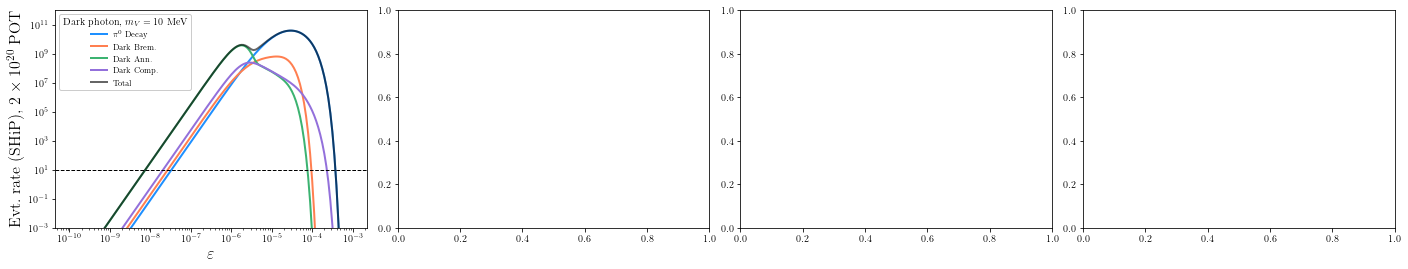

In [37]:
# kevin's EM samples
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
figwid = 24.0
fighei = 4
wwspace = 0.1

fig, axes = plt.subplots(1, 4, figsize=(figwid, fighei))

fig.subplots_adjust(wspace=wwspace)

ax = axes[0]
#ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec, er_DarkPhoton[:,0], color='brown', lw=2, label=r'$K^\pm\ \mathrm{Decay}$')
ax.plot(epsilon_vec, er_DarkPhoton[:,2], color='dodgerblue', lw=2, label=r'$\pi^0\ \mathrm{Decay}$')
ax.plot(epsilon_vec, er_DarkPhoton[:,3], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(epsilon_vec, er_DarkPhoton[:,5], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(epsilon_vec, er_DarkPhoton[:,4], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(epsilon_vec, np.sum(er_DarkPhoton, axis=1), color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$\mathrm{Dark\ photon,\ }m_V = 10\ \mathrm{MeV}$", title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$\varepsilon$", fontsize=16)
ax.set_ylabel(r"$\mathrm{Evt.\ rate\ (SHiP),\ }2\times 10^{20}\ \mathrm{POT}$", fontsize=16)
fig.savefig("/Users/taozhou/Desktop/BSM/SHiP_10MeV_Sensitivity_kevin.pdf", bbox_inches="tight")

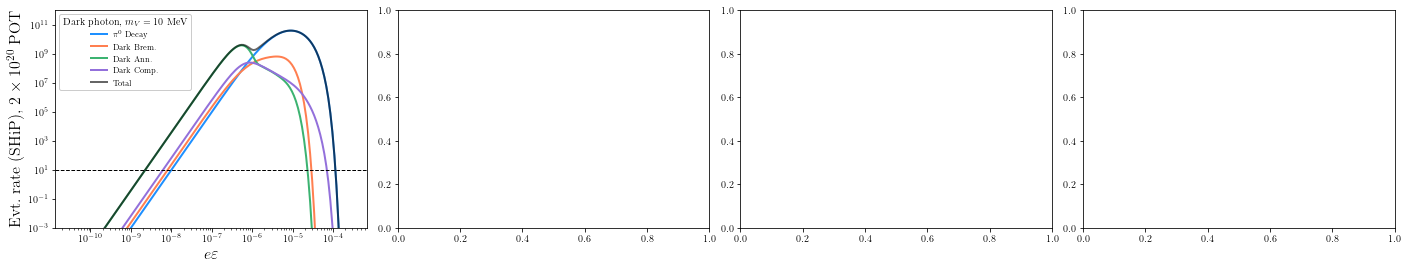

In [35]:
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
figwid = 24.0
fighei = 4
wwspace = 0.1

fig, axes = plt.subplots(1, 4, figsize=(figwid, fighei))

fig.subplots_adjust(wspace=wwspace)

ax = axes[0]
#ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec, er_DarkPhoton[:,0], color='brown', lw=2, label=r'$K^\pm\ \mathrm{Decay}$')
ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec, er_DarkPhoton[:,2], color='dodgerblue', lw=2, label=r'$\pi^0\ \mathrm{Decay}$')
ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec, er_DarkPhoton[:,3], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec, er_DarkPhoton[:,5], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec, er_DarkPhoton[:,4], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec, np.sum(er_DarkPhoton, axis=1), color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$\mathrm{Dark\ photon,\ }m_V = 10\ \mathrm{MeV}$", title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$e\varepsilon$", fontsize=16)
ax.set_ylabel(r"$\mathrm{Evt.\ rate\ (SHiP),\ }2\times 10^{20}\ \mathrm{POT}$", fontsize=16)

ax = axes[1]
ax.plot(g_vec, er_LeLmu[:,0]+er_LeLmu[:,1], color='brown', lw=2, label=r'$K^\pm\ \mathrm{Decay}$')
ax.plot(g_vec, er_LeLmu[:,2], color='dodgerblue', lw=2, label=r'$\pi^0\ \mathrm{Decay}$')
ax.plot(g_vec, er_LeLmu[:,3], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(g_vec, er_LeLmu[:,5], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(g_vec, er_LeLmu[:,4], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(g_vec, np.sum(er_LeLmu, axis=1), color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$L_e - L_\mu,\ m_V = 10\ \mathrm{MeV}$", title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$g_{e\mu}$", fontsize=16)
#ax.set_ylabel(r"$\mathrm{Evt.\ rate\ (SHiP),\ }2\times 10^{20}\ \mathrm{POT}$", fontsize=16)


ax = axes[2]
ax.plot(g_vec, er_LeLtau[:,0], color='brown', lw=2, label=r'$K^\pm\ \mathrm{Decay}$')
ax.plot(g_vec, er_LeLtau[:,2], color='dodgerblue', lw=2, label=r'$\pi^0\ \mathrm{Decay}$')
ax.plot(g_vec, er_LeLtau[:,3], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(g_vec, er_LeLtau[:,5], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(g_vec, er_LeLtau[:,4], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(g_vec, np.sum(er_LeLtau, axis=1), color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$L_e - L_\tau,\ m_V = 10\ \mathrm{MeV}$", title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$g_{e\tau}$", fontsize=16)
#ax.set_ylabel(r"$\mathrm{Evt.\ rate\ (SHiP),\ }2\times 10^{20}\ \mathrm{POT}$", fontsize=16)

ax = axes[3]
ax.plot(g_vec, er_LmuLtau[:,1], color='brown', lw=2, label=r'$K^\pm\ \mathrm{Decay}$')
ax.plot(g_vec, er_LmuLtau[:,2], color='dodgerblue', lw=2, label=r'$\pi^0\ \mathrm{Decay}$')
ax.plot(g_vec, er_LmuLtau[:,3], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(g_vec, er_LmuLtau[:,5], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(g_vec, er_LmuLtau[:,4], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(g_vec, np.sum(er_LmuLtau, axis=1), color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$L_\mu - L_\tau,\ m_V = 10\ \mathrm{MeV}$", title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$g_{\mu\tau}$", fontsize=16)
#ax.set_ylabel(r"$\mathrm{Evt.\ rate\ (SHiP),\ }2\times 10^{20}\ \mathrm{POT}$", fontsize=16)

fig.savefig("/Users/taozhou/Desktop/BSM/SHiP_10MeV_Sensitivity.pdf", bbox_inches="tight")

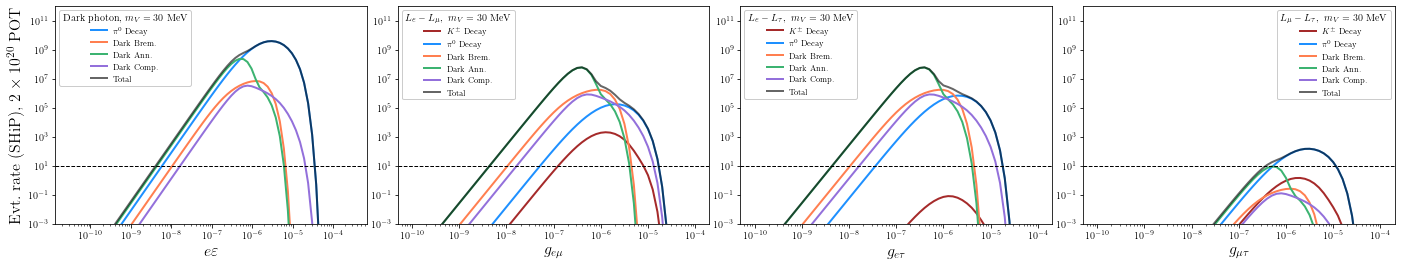

In [84]:
figwid = 24.0
fighei = 4
wwspace = 0.1

fig, axes = plt.subplots(1, 4, figsize=(figwid, fighei))

fig.subplots_adjust(wspace=wwspace)

ax = axes[0]
#ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec, er_DarkPhoton[:,0], color='brown', lw=2, label=r'$K^\pm\ \mathrm{Decay}$')
ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec_trim, er_DarkPhoton_30MeV[:,2], color='dodgerblue', lw=2, label=r'$\pi^0\ \mathrm{Decay}$')
ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec_trim, er_DarkPhoton_30MeV[:,3], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec_trim, er_DarkPhoton_30MeV[:,4], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec_trim, er_DarkPhoton_30MeV[:,5], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec_trim, np.sum(er_DarkPhoton_30MeV, axis=1), color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$\mathrm{Dark\ photon,\ }m_V = 30\ \mathrm{MeV}$", title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$e\varepsilon$", fontsize=16)
ax.set_ylabel(r"$\mathrm{Evt.\ rate\ (SHiP),\ }2\times 10^{20}\ \mathrm{POT}$", fontsize=16)

ax = axes[1]
ax.plot(g_vec_trim, er_LeLmu_30MeV[:,0]+er_LeLmu_30MeV[:,1], color='brown', lw=2, label=r'$K^\pm\ \mathrm{Decay}$')
ax.plot(g_vec_trim, er_LeLmu_30MeV[:,2], color='dodgerblue', lw=2, label=r'$\pi^0\ \mathrm{Decay}$')
ax.plot(g_vec_trim, er_LeLmu_30MeV[:,3], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(g_vec_trim, er_LeLmu_30MeV[:,4], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(g_vec_trim, er_LeLmu_30MeV[:,5], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(g_vec_trim, np.sum(er_LeLmu_30MeV, axis=1), color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$L_e - L_\mu,\ m_V = 30\ \mathrm{MeV}$", title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$g_{e\mu}$", fontsize=16)
#ax.set_ylabel(r"$\mathrm{Evt.\ rate\ (SHiP),\ }2\times 10^{20}\ \mathrm{POT}$", fontsize=16)


ax = axes[2]
ax.plot(g_vec_trim, er_LeLtau_30MeV[:,0], color='brown', lw=2, label=r'$K^\pm\ \mathrm{Decay}$')
ax.plot(g_vec_trim, er_LeLtau_30MeV[:,2], color='dodgerblue', lw=2, label=r'$\pi^0\ \mathrm{Decay}$')
ax.plot(g_vec_trim, er_LeLtau_30MeV[:,3], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(g_vec_trim, er_LeLtau_30MeV[:,4], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(g_vec_trim, er_LeLtau_30MeV[:,5], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(g_vec_trim, np.sum(er_LeLtau_30MeV, axis=1), color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$L_e - L_\tau,\ m_V = 30\ \mathrm{MeV}$", title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$g_{e\tau}$", fontsize=16)
#ax.set_ylabel(r"$\mathrm{Evt.\ rate\ (SHiP),\ }2\times 10^{20}\ \mathrm{POT}$", fontsize=16)

ax = axes[3]
ax.plot(g_vec_trim, er_LmuLtau_30MeV[:,1], color='brown', lw=2, label=r'$K^\pm\ \mathrm{Decay}$')
ax.plot(g_vec_trim, er_LmuLtau_30MeV[:,2], color='dodgerblue', lw=2, label=r'$\pi^0\ \mathrm{Decay}$')
ax.plot(g_vec_trim, er_LmuLtau_30MeV[:,3], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(g_vec_trim, er_LmuLtau_30MeV[:,4], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(g_vec_trim, er_LmuLtau_30MeV[:,5], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(g_vec_trim, np.sum(er_LmuLtau_30MeV, axis=1), color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$L_\mu - L_\tau,\ m_V = 30\ \mathrm{MeV}$", title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$g_{\mu\tau}$", fontsize=16)
#ax.set_ylabel(r"$\mathrm{Evt.\ rate\ (SHiP),\ }2\times 10^{20}\ \mathrm{POT}$", fontsize=16)

fig.savefig("/Users/taozhou/Desktop/BSM/SHiP_30MeV_Sensitivity.pdf", bbox_inches="tight")

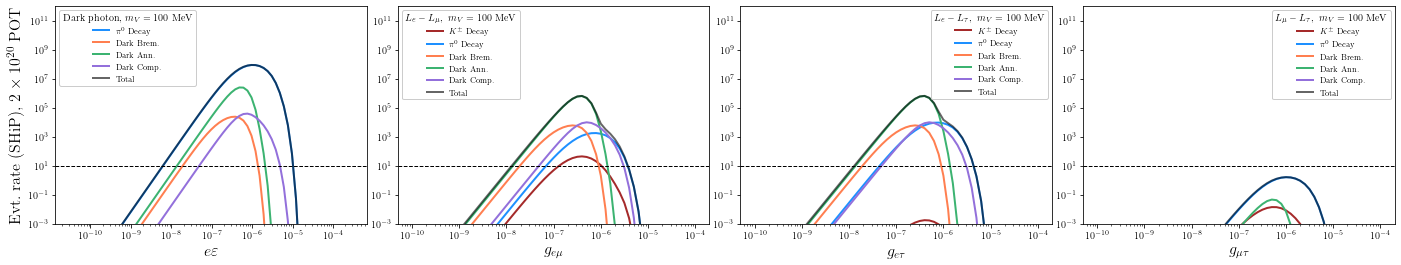

In [85]:
figwid = 24.0
fighei = 4
wwspace = 0.1

fig, axes = plt.subplots(1, 4, figsize=(figwid, fighei))

fig.subplots_adjust(wspace=wwspace)

ax = axes[0]
#ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec, er_DarkPhoton[:,0], color='brown', lw=2, label=r'$K^\pm\ \mathrm{Decay}$')
ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec_trim, er_DarkPhoton_100MeV[:,2], color='dodgerblue', lw=2, label=r'$\pi^0\ \mathrm{Decay}$')
ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec_trim, er_DarkPhoton_100MeV[:,3], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec_trim, er_DarkPhoton_100MeV[:,4], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec_trim, er_DarkPhoton_100MeV[:,5], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(np.sqrt(4.0*np.pi*alpha_em)*epsilon_vec_trim, np.sum(er_DarkPhoton_100MeV, axis=1), color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$\mathrm{Dark\ photon,\ }m_V = 100\ \mathrm{MeV}$", title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$e\varepsilon$", fontsize=16)
ax.set_ylabel(r"$\mathrm{Evt.\ rate\ (SHiP),\ }2\times 10^{20}\ \mathrm{POT}$", fontsize=16)

ax = axes[1]
ax.plot(g_vec_trim, er_LeLmu_100MeV[:,0]+er_LeLmu_100MeV[:,1], color='brown', lw=2, label=r'$K^\pm\ \mathrm{Decay}$')
ax.plot(g_vec_trim, er_LeLmu_100MeV[:,2], color='dodgerblue', lw=2, label=r'$\pi^0\ \mathrm{Decay}$')
ax.plot(g_vec_trim, er_LeLmu_100MeV[:,3], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(g_vec_trim, er_LeLmu_100MeV[:,4], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(g_vec_trim, er_LeLmu_100MeV[:,5], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(g_vec_trim, np.sum(er_LeLmu_100MeV, axis=1), color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$L_e - L_\mu,\ m_V = 100\ \mathrm{MeV}$", title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$g_{e\mu}$", fontsize=16)
#ax.set_ylabel(r"$\mathrm{Evt.\ rate\ (SHiP),\ }2\times 10^{20}\ \mathrm{POT}$", fontsize=16)


ax = axes[2]
ax.plot(g_vec_trim, er_LeLtau_100MeV[:,0], color='brown', lw=2, label=r'$K^\pm\ \mathrm{Decay}$')
ax.plot(g_vec_trim, er_LeLtau_100MeV[:,2], color='dodgerblue', lw=2, label=r'$\pi^0\ \mathrm{Decay}$')
ax.plot(g_vec_trim, er_LeLtau_100MeV[:,3], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(g_vec_trim, er_LeLtau_100MeV[:,4], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(g_vec_trim, er_LeLtau_100MeV[:,5], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(g_vec_trim, np.sum(er_LeLtau_100MeV, axis=1), color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$L_e - L_\tau,\ m_V = 100\ \mathrm{MeV}$", title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$g_{e\tau}$", fontsize=16)
#ax.set_ylabel(r"$\mathrm{Evt.\ rate\ (SHiP),\ }2\times 10^{20}\ \mathrm{POT}$", fontsize=16)

ax = axes[3]
ax.plot(g_vec_trim, er_LmuLtau_100MeV[:,1], color='brown', lw=2, label=r'$K^\pm\ \mathrm{Decay}$')
ax.plot(g_vec_trim, er_LmuLtau_100MeV[:,2], color='dodgerblue', lw=2, label=r'$\pi^0\ \mathrm{Decay}$')
ax.plot(g_vec_trim, er_LmuLtau_100MeV[:,3], color='coral', lw=2, label=r'$\mathrm{Dark\ Brem.}$')
ax.plot(g_vec_trim, er_LmuLtau_100MeV[:,4], color='mediumseagreen', lw=2, label=r'$\mathrm{Dark\ Ann.}$')
ax.plot(g_vec_trim, er_LmuLtau_100MeV[:,5], color='mediumpurple', lw=2, label=r'$\mathrm{Dark\ Comp.}$')
ax.plot(g_vec_trim, np.sum(er_LmuLtau_100MeV, axis=1), color='k', lw=2, alpha=0.6, label=r"$\mathrm{Total}$")
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim(1e-3, 1e12)
ax.legend(loc='best', fontsize=8, framealpha=1.0, title=r"$L_\mu - L_\tau,\ m_V = 100\ \mathrm{MeV}$", title_fontsize=10)
ax.axhline(10.0, lw=1, ls='--', color='k')
ax.set_xlabel(r"$g_{\mu\tau}$", fontsize=16)
#ax.set_ylabel(r"$\mathrm{Evt.\ rate\ (SHiP),\ }2\times 10^{20}\ \mathrm{POT}$", fontsize=16)

fig.savefig("/Users/taozhou/Desktop/BSM/SHiP_100MeV_Sensitivity.pdf", bbox_inches="tight")

In [ ]:
spectrum_10MeV_pion = detector_cut(NewShower_pion[0], [85.0], 3.19, method="Sample", energy_cut=None)[0]
spectrum_10MeV_kaon_mu = detector_cut(NewShower_mu[0], [85.0], 3.19, method="Sample", energy_cut=None)[0]
spectrum_10MeV_kaon_e = detector_cut(NewShower_e[0], [85.0], 3.19, method="Sample", energy_cut=None)[0]
tao_events = pk.load(open(PETITE_home_dir+dictionary_dir+"energy_weights_particles.pkl", "rb"))
tao_darkbrem_nocuts = np.concatenate([tao_events[2]['DarkBrem'][11], tao_events[2]['DarkBrem'][-11]])
tao_darkcomp_nocuts = tao_events[2]['DarkComp'][22]
tao_dakann_nocuts = tao_events[2]['DarkAnn'][-11]
tao_darkbrem_cuts = detector_cut(tao_darkbrem_nocuts, [85.0], 3.19, method="Sample", energy_cut=None)[0]
tao_darkcomp_cuts = detector_cut(tao_darkcomp_nocuts, [85.0], 3.19, method="Sample", energy_cut=None)[0]
tao_darkann_cuts = detector_cut(tao_dakann_nocuts, [85.0], 3.19, method="Sample", energy_cut=None)[0]
np.sum([p0.get_ids()["weight"] for p0 in tao_darkbrem_cuts])/np.sum([p0.get_ids()["weight"] for p0 in tao_darkbrem_nocuts])

0.31750914656338103

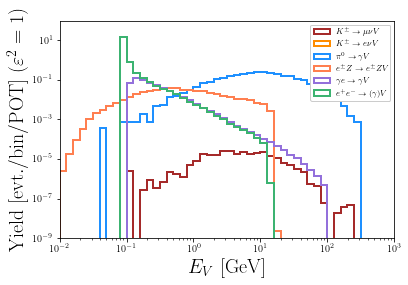

In [ ]:
plt.hist([p0.get_p0()[0] for p0 in spectrum_10MeV_kaon_mu], weights=[p0.get_ids()['weight'] for p0 in spectrum_10MeV_kaon_mu], bins=np.logspace(-2, 3, 51), lw=2, histtype="step", color="brown", label=r"$K^\pm \to \mu \nu V$")
plt.hist([p0.get_p0()[0] for p0 in spectrum_10MeV_kaon_e], weights=[p0.get_ids()['weight'] for p0 in spectrum_10MeV_kaon_e], bins=np.logspace(-2, 3, 51), lw=2, histtype="step", color="darkorange", label=r"$K^\pm \to e \nu V$")
plt.hist([p0.get_p0()[0] for p0 in spectrum_10MeV_pion], weights=[p0.get_ids()['weight'] for p0 in spectrum_10MeV_pion], bins=np.logspace(-2, 3, 51), lw=2, histtype="step", color="dodgerblue", label=r"$\pi^0 \to \gamma V$")
plt.hist([p0.get_p0()[0] for p0 in tao_darkbrem_cuts], weights=[p0.get_ids()['weight'] for p0 in tao_darkbrem_cuts], bins=np.logspace(-2, 3, 51), lw=2, histtype="step", color="coral", label=r"$e^\pm Z \to e^\pm Z V$")
plt.hist([p0.get_p0()[0] for p0 in tao_darkcomp_cuts], weights=[p0.get_ids()['weight'] for p0 in tao_darkcomp_cuts], bins=np.logspace(-2, 3, 51), lw=2, histtype="step", color="mediumpurple", label=r"$\gamma e \to \gamma V$")
plt.hist([p0.get_p0()[0] for p0 in tao_darkann_cuts], weights=[p0.get_ids()['weight'] for p0 in tao_darkann_cuts], bins=np.logspace(-2, 3, 51), lw=2, histtype="step", color="mediumseagreen", label=r"$e^+ e^- \to (\gamma) V$")
plt.gca().set_xscale('log')
plt.gca().set_yscale('log')
plt.gca().axis([0.01, 1000, 1e-9, 100])

plt.gca().set_xlabel(r"$E_V\ \mathrm{[GeV]}$", size=20)
plt.gca().set_ylabel(r"$\mathrm{Yield\ [evt./bin/POT]\ } (\varepsilon^2 = 1)$", size=20)
plt.legend(loc='best', framealpha=1.0, fontsize=8)
plt.savefig("/Users/taozhou/Desktop/BSM/SHiP_10MeV_Spectrum_newgeometry.pdf", bbox_inches="tight")

In [ ]:
spectrum_30MeV_pion = detector_cut(NewShower_pion_30MeV[0], [85.0], 3.19, method="Sample", energy_cut=None)[0]
spectrum_30MeV_kaon_mu = detector_cut(NewShower_30MeV_mu[0], [85.0], 3.19, method="Sample", energy_cut=None)[0]
spectrum_30MeV_kaon_e = detector_cut(NewShower_30MeV_e[0], [85.0], 3.19, method="Sample", energy_cut=None)[0]
tao_events = pk.load(open(PETITE_home_dir+dictionary_dir+"energy_weights_particles.pkl", "rb"))
tao_darkbrem_nocuts = np.concatenate([tao_events[2]['DarkBrem'][11], tao_events[2]['DarkBrem'][-11]])
tao_darkcomp_nocuts = tao_events[2]['DarkComp'][22]
tao_dakann_nocuts = tao_events[2]['DarkAnn'][-11]
tao_darkbrem_cuts = detector_cut(tao_darkbrem_nocuts, [85.0], 3.19, method="Sample", energy_cut=None)[0]
tao_darkcomp_cuts = detector_cut(tao_darkcomp_nocuts, [85.0], 3.19, method="Sample", energy_cut=None)[0]
tao_darkann_cuts = detector_cut(tao_dakann_nocuts, [85.0], 3.19, method="Sample", energy_cut=None)[0]
np.sum([p0.get_ids()["weight"] for p0 in tao_darkbrem_cuts])/np.sum([p0.get_ids()["weight"] for p0 in tao_darkbrem_nocuts])